In [1]:
import pandas as pd
from fbprophet import Prophet

In [2]:
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pytz import timezone as tz

In [3]:
from time import time
from datetime import date
from datetime import datetime

In [4]:
# Measure performance:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
df_energy = pd.read_csv('../data/'+ "eco2mix-regional-cons-def.csv", sep=";",
                parse_dates=["Date - Heure"]).sort_values(by=["Région", "Date - Heure"])

In [6]:
df_energy = df_energy[["Région", "Date - Heure", "Consommation (MW)"]]

In [7]:
df_energy.fillna(df_energy.dropna()["Consommation (MW)"].mean(), inplace=True)

In [8]:
df_energy.isnull().sum()

Région               0
Date - Heure         0
Consommation (MW)    0
dtype: int64

In [9]:
df_energy.dtypes

Région                object
Date - Heure          object
Consommation (MW)    float64
dtype: object

In [10]:
df_energy.fillna(df_energy.dropna()["Consommation (MW)"].mean(), inplace=True)
df_energy["date"] = df_energy["Date - Heure"].apply(lambda x: x + timedelta(minutes=x.minute))
df_energy["date"] = df_energy["date"].apply(lambda x: x.astimezone(tz("UTC")))
df_energy["date"] = df_energy["date"].apply(lambda x: x.fromtimestamp(x.timestamp()))
df_energy.head(3)

,Région,Date - Heure,Consommation (MW),date
147167,Auvergne-Rhône-Alpes,2013-01-01 00:00:00+01:00,4528.493194,2013-01-01 00:00:00
147170,Auvergne-Rhône-Alpes,2013-01-01 00:30:00+01:00,8173.000000,2013-01-01 01:00:00
1017843,Auvergne-Rhône-Alpes,2013-01-01 01:00:00+01:00,7944.000000,2013-01-01 01:00:00


In [11]:
df_energy.head()

,Région,Date - Heure,Consommation (MW),date
147167,Auvergne-Rhône-Alpes,2013-01-01 00:00:00+01:00,4528.493194,2013-01-01 00:00:00
147170,Auvergne-Rhône-Alpes,2013-01-01 00:30:00+01:00,8173.000000,2013-01-01 01:00:00
1017843,Auvergne-Rhône-Alpes,2013-01-01 01:00:00+01:00,7944.000000,2013-01-01 01:00:00
147173,Auvergne-Rhône-Alpes,2013-01-01 01:30:00+01:00,7896.000000,2013-01-01 02:00:00
1017845,Auvergne-Rhône-Alpes,2013-01-01 02:00:00+01:00,7882.000000,2013-01-01 02:00:00


In [12]:
# group by day:
df_region_per_hour = df_energy.groupby(["Région", "date"], as_index=False).agg({"Consommation (MW)": np.sum})

In [13]:
df_region_per_hour.head()

,Région,date,Consommation (MW)
0,Auvergne-Rhône-Alpes,2013-01-01 00:00:00,4528.493194
1,Auvergne-Rhône-Alpes,2013-01-01 01:00:00,16117.000000
2,Auvergne-Rhône-Alpes,2013-01-01 02:00:00,15778.000000
3,Auvergne-Rhône-Alpes,2013-01-01 03:00:00,15618.000000
4,Auvergne-Rhône-Alpes,2013-01-01 04:00:00,14944.000000


In [14]:
df_region_per_hour.dtypes

Région                       object
date                 datetime64[ns]
Consommation (MW)           float64
dtype: object

# Filter on Ile de France

In [15]:
df_region_per_hour_ile_de_france = df_region_per_hour[df_region_per_hour['Région']=='Ile-de-France']

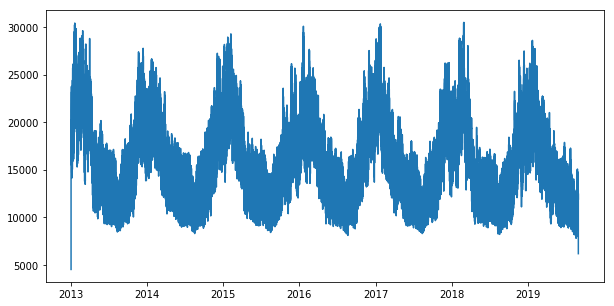

In [16]:
plt.figure(figsize=(10,5))
plt.plot(df_region_per_hour_ile_de_france["date"], df_region_per_hour_ile_de_france["Consommation (MW)"])

In [17]:
#restraindre la durée

In [18]:
df_region_per_hour_ile_de_france_small = df_region_per_hour_ile_de_france[(df_region_per_hour_ile_de_france['date']>='2017-01-01 00:00:00')&(df_region_per_hour_ile_de_france['date']<'2019-01-15 00:00:00')]




In [19]:
df_region_per_hour_ile_de_france_small.to_csv('../data/ile_de_france_dataset.csv')

# Prophet for forcasting Ile de France energy

In [20]:
df_region_per_hour_ile_de_france_small.dtypes

Région                       object
date                 datetime64[ns]
Consommation (MW)           float64
dtype: object

In [21]:
df_region_per_hour_ile_de_france_small.head()

,Région,date,Consommation (MW)
385520,Ile-de-France,2017-01-01 00:00:00,24147.0
385521,Ile-de-France,2017-01-01 01:00:00,23337.0
385522,Ile-de-France,2017-01-01 02:00:00,22179.0
385523,Ile-de-France,2017-01-01 03:00:00,21433.0
385524,Ile-de-France,2017-01-01 04:00:00,20597.0


In [22]:
df_region_per_hour_ile_de_france_small['date_time']=pd.to_datetime(df_region_per_hour_ile_de_france_small['date'], format='%Y-%m-%d')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
df_region_per_hour_ile_de_france_small.head()

,Région,date,Consommation (MW),date_time
385520,Ile-de-France,2017-01-01 00:00:00,24147.0,2017-01-01 00:00:00
385521,Ile-de-France,2017-01-01 01:00:00,23337.0,2017-01-01 01:00:00
385522,Ile-de-France,2017-01-01 02:00:00,22179.0,2017-01-01 02:00:00
385523,Ile-de-France,2017-01-01 03:00:00,21433.0,2017-01-01 03:00:00
385524,Ile-de-France,2017-01-01 04:00:00,20597.0,2017-01-01 04:00:00


In [24]:
df_region_per_hour_ile_de_france_small.dtypes

Région                       object
date                 datetime64[ns]
Consommation (MW)           float64
date_time            datetime64[ns]
dtype: object

In [25]:
# Select training set:
df_region_per_hour_ile_de_france_small_train = df_region_per_hour_ile_de_france_small[(df_region_per_hour_ile_de_france_small['date_time']<='2018-12-31 23:00:00')]



In [26]:
df_region_per_hour_ile_de_france_small_train.tail()

,Région,date,Consommation (MW),date_time
403033,Ile-de-France,2018-12-31 19:00:00,20763.0,2018-12-31 19:00:00
403034,Ile-de-France,2018-12-31 20:00:00,20236.0,2018-12-31 20:00:00
403035,Ile-de-France,2018-12-31 21:00:00,18923.0,2018-12-31 21:00:00
403036,Ile-de-France,2018-12-31 22:00:00,17614.0,2018-12-31 22:00:00
403037,Ile-de-France,2018-12-31 23:00:00,18173.0,2018-12-31 23:00:00


In [27]:
df_region_per_hour_ile_de_france_small_train.tail()

,Région,date,Consommation (MW),date_time
403033,Ile-de-France,2018-12-31 19:00:00,20763.0,2018-12-31 19:00:00
403034,Ile-de-France,2018-12-31 20:00:00,20236.0,2018-12-31 20:00:00
403035,Ile-de-France,2018-12-31 21:00:00,18923.0,2018-12-31 21:00:00
403036,Ile-de-France,2018-12-31 22:00:00,17614.0,2018-12-31 22:00:00
403037,Ile-de-France,2018-12-31 23:00:00,18173.0,2018-12-31 23:00:00


In [28]:
model_energy = Prophet(interval_width=0.9)


In [29]:
df_region_per_hour_ile_de_france_small_train.rename(columns={"date_time": "ds"}, inplace=True)
df_region_per_hour_ile_de_france_small_train.rename(columns={"Consommation (MW)": "y"}, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
df_prophet_train = df_region_per_hour_ile_de_france_small_train[['ds','y']]

In [31]:
df_prophet_train.tail()

,ds,y
403033,2018-12-31 19:00:00,20763.0
403034,2018-12-31 20:00:00,20236.0
403035,2018-12-31 21:00:00,18923.0
403036,2018-12-31 22:00:00,17614.0
403037,2018-12-31 23:00:00,18173.0


In [32]:
df_prophet_train.count()

ds    17518
y     17518
dtype: int64

In [33]:
# It takes me 45 min to train a model  over 5 years !

In [34]:
start_time = time()
model_energy.fit(df_prophet_train)
end_time = time()
print ("This model took %.2f seconds to train" % (end_time - start_time))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



This model took 29.82 seconds to train


In [35]:
future_ile_de_france_energy_date_2019 = model_energy.make_future_dataframe(periods=14*24,freq='H', include_history = False)


In [36]:
future_ile_de_france_energy_date_2019.tail(100)

,ds
236,2019-01-10 20:00:00
237,2019-01-10 21:00:00
238,2019-01-10 22:00:00
239,2019-01-10 23:00:00
240,2019-01-11 00:00:00
241,2019-01-11 01:00:00
242,2019-01-11 02:00:00
243,2019-01-11 03:00:00
244,2019-01-11 04:00:00
245,2019-01-11 05:00:00


In [37]:
start_time = time()
future_energy_forcast_ile_de_france_2019 = model_energy.predict(future_ile_de_france_energy_date_2019)
end_time = time()
print ("This took %.2f seconds" % (end_time - start_time))

This took 2.99 seconds


In [38]:
future_energy_forcast_ile_de_france_2019[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].count()

ds            336
yhat          336
yhat_lower    336
yhat_upper    336
dtype: int64

df_region_per_day_ile_de_france_2017_2018.head()

In [39]:
future_energy_forcast_ile_de_france_2019_plot= future_energy_forcast_ile_de_france_2019

In [40]:
df_region_per_hour_ile_de_france_plot=df_region_per_hour_ile_de_france_small

In [41]:
import matplotlib

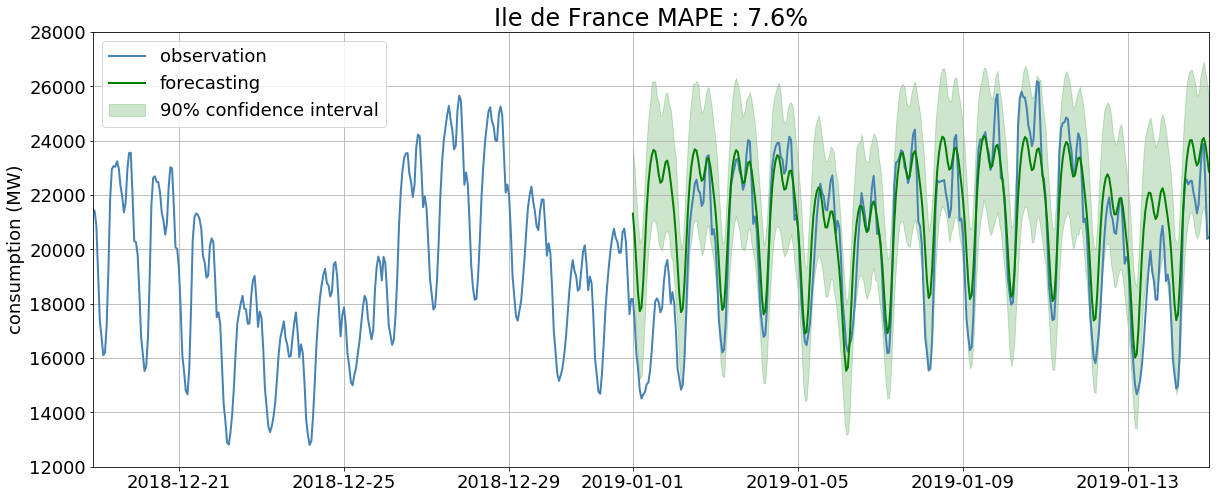

In [79]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,8),linewidth=2)
plt.plot(df_region_per_hour_ile_de_france_plot[-650:].date,df_region_per_hour_ile_de_france_plot[-650:]['Consommation (MW)'],color='steelblue',label='observation',linewidth=2.0)
plt.plot(future_energy_forcast_ile_de_france_2019_plot.ds.dt.to_pydatetime(),future_energy_forcast_ile_de_france_2019_plot.yhat,color='g',label='forecasting',linewidth=2.0)

plt.fill_between(future_energy_forcast_ile_de_france_2019_plot.ds.dt.to_pydatetime(), future_energy_forcast_ile_de_france_2019_plot['yhat_lower'], future_energy_forcast_ile_de_france_2019_plot['yhat_upper'],
                        color='green', alpha=0.2,label='90% confidence interval' )
plt.title('Ile de France' + " MAPE : {}%".format(str(round(100*0.07581, 1))))
plt.grid(which='both')
plt.ylim([12000, 28000])

plt.ylabel("consumption (MW)")
plt.rc('xtick', labelsize=18)  
plt.rc('ytick', labelsize=18)# fontsize of the axes title
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=18)
plt.margins(0)
plt.legend()


In [46]:
y_true = df_region_per_hour_ile_de_france_small[(df_region_per_hour_ile_de_france_small['date_time'] >= '2019-01-01')&(df_region_per_hour_ile_de_france_small['date_time'] < '2019-01-15')]['Consommation (MW)']


In [47]:
y_pred = future_energy_forcast_ile_de_france_2019['yhat']

In [48]:
mean_absolute_percentage_error(y_true, y_pred)

7.5817736798973385

# Add meteo:

In [50]:
full_meteo = pd.read_csv("../data/full_meteo.csv", parse_dates=["DATE"]).rename(
columns={"MAX_TEMP": "max_temp_paris"})[["DATE", "max_temp_paris"]]
last_meteo_paris = pd.read_csv('../data/' + "meteo_paris_2019_juin_sept.csv",
                               sep=";", parse_dates=["DATE"]).rename(columns={"MAX_TEMP": "max_temp_paris"})
full_meteo = pd.concat([full_meteo, last_meteo_paris], axis=0)
full_meteo["DATE"] = full_meteo["DATE"].apply(lambda x: x.date())
full_meteo.tail(10)

,DATE,max_temp_paris
112,2019-09-21,28.0
113,2019-09-22,22.0
114,2019-09-23,22.0
115,2019-09-24,20.0
116,2019-09-25,18.0
117,2019-09-26,21.0
118,2019-09-27,21.0
119,2019-09-28,19.0
120,2019-09-29,19.0
121,2019-09-30,20.0


In [51]:
df_region_per_hour_ile_de_france = df_region_per_hour_ile_de_france_small

In [52]:
df_region_per_hour_ile_de_france.head()

,Région,date,Consommation (MW),date_time
385520,Ile-de-France,2017-01-01 00:00:00,24147.0,2017-01-01 00:00:00
385521,Ile-de-France,2017-01-01 01:00:00,23337.0,2017-01-01 01:00:00
385522,Ile-de-France,2017-01-01 02:00:00,22179.0,2017-01-01 02:00:00
385523,Ile-de-France,2017-01-01 03:00:00,21433.0,2017-01-01 03:00:00
385524,Ile-de-France,2017-01-01 04:00:00,20597.0,2017-01-01 04:00:00


In [53]:
df_region_per_hour_ile_de_france.dtypes

Région                       object
date                 datetime64[ns]
Consommation (MW)           float64
date_time            datetime64[ns]
dtype: object

In [54]:
df_temp = df_region_per_hour_ile_de_france.copy()
df_temp["DATE"] = df_temp["date"].apply(lambda x: x.date())

df_temp = pd.merge(df_temp, full_meteo[["DATE", "max_temp_paris"]], on="DATE", how="left").drop("DATE", axis=1)
df_temp.tail(1)

,Région,date,Consommation (MW),date_time,max_temp_paris
17853,Ile-de-France,2019-01-14 23:00:00,20468.0,2019-01-14 23:00:00,9.0


In [55]:
# Select training set:
df_temp_train = df_temp[(df_temp['date']<'2019-01-01')]



In [56]:
df_temp_train.tail()

,Région,date,Consommation (MW),date_time,max_temp_paris
17513,Ile-de-France,2018-12-31 19:00:00,20763.0,2018-12-31 19:00:00,10.0
17514,Ile-de-France,2018-12-31 20:00:00,20236.0,2018-12-31 20:00:00,10.0
17515,Ile-de-France,2018-12-31 21:00:00,18923.0,2018-12-31 21:00:00,10.0
17516,Ile-de-France,2018-12-31 22:00:00,17614.0,2018-12-31 22:00:00,10.0
17517,Ile-de-France,2018-12-31 23:00:00,18173.0,2018-12-31 23:00:00,10.0


In [57]:
model_energy_meteo = Prophet()

In [58]:
model_energy_meteo.add_regressor('max_temp_paris')

In [59]:
df_temp_train.rename(columns={"date": "ds"}, inplace=True)
df_temp_train.rename(columns={"Consommation (MW)": "y"}, inplace=True)

In [60]:
df_temp_train.head()

,Région,ds,y,date_time,max_temp_paris
0,Ile-de-France,2017-01-01 00:00:00,24147.0,2017-01-01 00:00:00,3.0
1,Ile-de-France,2017-01-01 01:00:00,23337.0,2017-01-01 01:00:00,3.0
2,Ile-de-France,2017-01-01 02:00:00,22179.0,2017-01-01 02:00:00,3.0
3,Ile-de-France,2017-01-01 03:00:00,21433.0,2017-01-01 03:00:00,3.0
4,Ile-de-France,2017-01-01 04:00:00,20597.0,2017-01-01 04:00:00,3.0


In [61]:
model_energy_meteo.fit(df_temp_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [62]:
future_ile_de_france_energy_2019_meteo_date = model_energy_meteo.make_future_dataframe(periods=14*24,freq='H', include_history = False)


In [63]:
future_ile_de_france_energy_2019_meteo_date['max_temp_paris']=df_temp[(df_temp['date']>='2019-01-01')&(df_temp['date']<'2019-01-15')]['max_temp_paris'].to_numpy()



In [64]:
future_ile_de_france_energy_2019_meteo_date.tail()

,ds,max_temp_paris
331,2019-01-14 19:00:00,9.0
332,2019-01-14 20:00:00,9.0
333,2019-01-14 21:00:00,9.0
334,2019-01-14 22:00:00,9.0
335,2019-01-14 23:00:00,9.0


In [65]:
future_energy_forcast_ile_de_france_2019_meteo = model_energy_meteo.predict(future_ile_de_france_energy_2019_meteo_date)

In [66]:
future_energy_forcast_ile_de_france_2019_meteo[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
326,2019-01-14 14:00:00,22844.173182,20965.582686,24708.713368
327,2019-01-14 15:00:00,22431.032060,20729.502408,24373.284872
328,2019-01-14 16:00:00,22184.296516,20239.348610,24138.432713
329,2019-01-14 17:00:00,22301.982532,20350.381670,24207.353528
330,2019-01-14 18:00:00,22708.316201,20963.401651,24579.637325
331,2019-01-14 19:00:00,23101.731124,21192.082763,24900.487521
332,2019-01-14 20:00:00,23196.519837,21249.619553,25140.028661
333,2019-01-14 21:00:00,22933.844097,21078.347644,24835.856246
334,2019-01-14 22:00:00,22467.406880,20609.303629,24297.973225
335,2019-01-14 23:00:00,21953.728304,20135.588304,23674.084054


In [67]:
future_energy_forcast_ile_de_france_2019_meteo_plot= future_energy_forcast_ile_de_france_2019_meteo


In [68]:
future_energy_forcast_ile_de_france_2019_meteo_plot.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,max_temp_paris,max_temp_paris_lower,max_temp_paris_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
331,2019-01-14 19:00:00,19556.313480,21192.082763,24900.487521,19311.463901,19761.869943,3545.417644,3545.417644,3545.417644,1588.978500,1588.978500,1588.978500,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,564.406940,564.406940,564.406940,0.0,0.0,0.0,23101.731124
332,2019-01-14 20:00:00,19558.008228,21249.619553,25140.028661,19312.052412,19766.658492,3638.511609,3638.511609,3638.511609,1645.168728,1645.168728,1645.168728,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,601.310676,601.310676,601.310676,0.0,0.0,0.0,23196.519837
333,2019-01-14 21:00:00,19559.702977,21078.347644,24835.856246,19312.647488,19774.222286,3374.141120,3374.141120,3374.141120,1348.087201,1348.087201,1348.087201,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,634.021714,634.021714,634.021714,0.0,0.0,0.0,22933.844097
334,2019-01-14 22:00:00,19561.397726,20609.303629,24297.973225,19313.413003,19779.492887,2906.009154,2906.009154,2906.009154,851.332621,851.332621,851.332621,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,662.644329,662.644329,662.644329,0.0,0.0,0.0,22467.406880
335,2019-01-14 23:00:00,19563.092475,20135.588304,23674.084054,19312.743142,19782.083378,2390.635829,2390.635829,2390.635829,311.289509,311.289509,311.289509,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,1392.032204,687.314116,687.314116,687.314116,0.0,0.0,0.0,21953.728304


In [69]:
import matplotlib

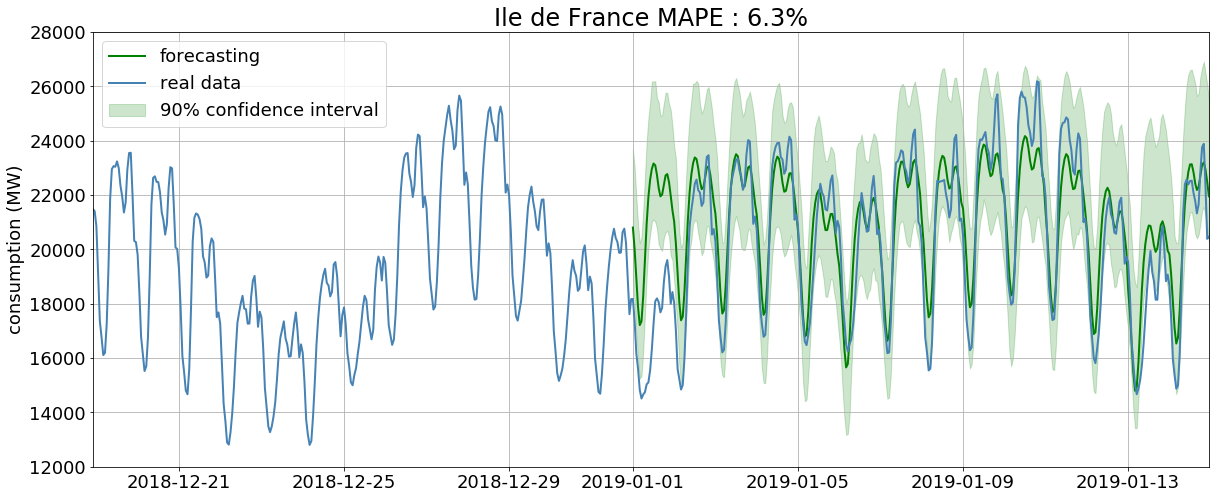

In [80]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,8),linewidth=2)
plt.plot(future_energy_forcast_ile_de_france_2019_meteo_plot.ds.dt.to_pydatetime(),future_energy_forcast_ile_de_france_2019_meteo_plot.yhat,color='green',label='forecasting',linewidth=2.0)
plt.plot(df_region_per_hour_ile_de_france_plot[-650:].date,df_region_per_hour_ile_de_france_plot[-650:]['Consommation (MW)'],color='steelblue',label='real data',linewidth=2.0)
plt.fill_between(future_energy_forcast_ile_de_france_2019_plot.ds.dt.to_pydatetime(), future_energy_forcast_ile_de_france_2019_plot['yhat_lower'], future_energy_forcast_ile_de_france_2019_plot['yhat_upper'],
                        color='green', alpha=0.2, label='90% confidence interval')
plt.title('Ile de France' + " MAPE : {}%".format(str(round(100*0.062957, 1))))
plt.grid(which='both')
plt.ylim([12000, 28000])

plt.ylabel("consumption (MW)")
plt.rc('xtick', labelsize=18)  
plt.rc('ytick', labelsize=18)# fontsize of the axes title
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=18)
plt.margins(0)
plt.legend()

In [67]:
#measure performance:

In [71]:
y_true = df_region_per_hour_ile_de_france_small[(df_region_per_hour_ile_de_france_small['date_time'] >= '2019-01-01')&(df_region_per_hour_ile_de_france_small['date_time'] < '2019-01-15')]['Consommation (MW)']


In [72]:
y_pred_meteo = future_energy_forcast_ile_de_france_2019_meteo['yhat']

In [73]:
mean_absolute_percentage_error(y_true, y_pred_meteo)

6.29570846431837